In [1]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os

In [2]:
modeledWorld1 = ModeledPopulatedWorld(500,20)
print('number of households: ', len([h for h in modeledWorld1.locations.values() if h.location_type=='home']))
print('people in world: ', len(modeledWorld1.people))

number of households:  129
people in world:  383


In [3]:
simulation1 = Simulation(modeledWorld1,200)


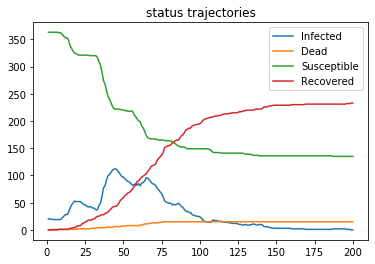

In [4]:
simulation1.plot_status_timecourse()


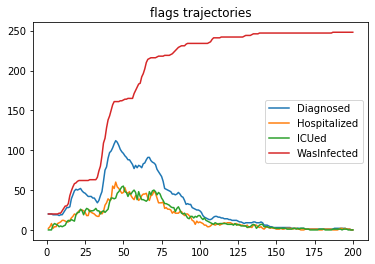

In [5]:
simulation1.plot_flags_timecourse()


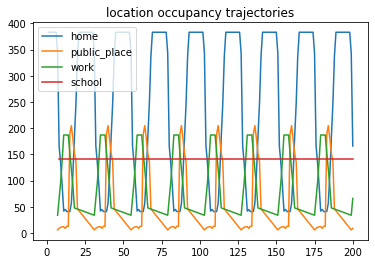

In [6]:
simulation1.plot_location_type_occupancy_timecourse()

In [7]:
simulation1.export_time_courses_as_csvs(identifier='testing')

